In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from keras.applications import vgg16

In [3]:
train_path = os.getcwd()+'/cats and dogs/training_set'
test_path = os.getcwd() + '/cats and dogs/test_set'

In [4]:
BATCH = 32
IMG_SIZE = 150

In [5]:
def tensor_pipeline():
    train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                                batch_size=BATCH,
                                                                 image_size=(IMG_SIZE,IMG_SIZE),
                                                                 validation_split=0.2,
                                                                 seed=123,
                                                                 subset='training')
    validation_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                                      batch_size=BATCH,
                                                                      image_size=(100,100),
                                                                      validation_split=0.2,
                                                                      seed=123,
                                                                      subset='validation')
    test_dataset = keras.preprocessing.image_dataset_from_directory(test_path,
                                                                      batch_size=BATCH,
                                                                      image_size=(100,100),)
    Rescale = layers.experimental.preprocessing.Rescaling(1/255.0)
    train_ds = train_dataset.map(lambda x,y : (Rescale(x),y))
    val_ds = validation_dataset.map(lambda x,y : (Rescale(x),y))
    test_ds = test_dataset.map(lambda x,y : (Rescale(x),y))


    # only done for training data in tensorflow guide
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds,val_ds,test_ds

In [6]:
def keras_pipeline():
    train_gen = keras.preprocessing.image.ImageDataGenerator(
                                                            rescale= 1./255,
                                                            rotation_range=40,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            horizontal_flip=True)
    test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
    
    train_gen = train_gen.flow_from_directory(train_path,target_size=(IMG_SIZE,IMG_SIZE),batch_size=BATCH,class_mode='binary')
    test_gen = test_gen.flow_from_directory(test_path,target_size=(IMG_SIZE,IMG_SIZE),batch_size=BATCH,class_mode='binary')
    return train_gen ,test_gen

In [7]:
per_epoch_stop = math.ceil(8005/BATCH)
per_epoch_stop_val = math.ceil(2023/BATCH)

In [8]:
train_gen,test_gen = keras_pipeline()

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
for a in test_dataset.take(1):
    print(a[1])
    break

In [11]:
conv_base = vgg16.VGG16(include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

Metal device set to: Apple M1


2021-10-01 14:05:57.199916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-01 14:05:57.200366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


58900480/58889256 [==============================] - 10s 0us/step


In [28]:
conv_base.trainable = True

In [29]:
[e.name for e in conv_base.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [30]:
train_layer = False
for layer in conv_base.layers:
    if(layer.name == 'block5_conv1'):
        train_layer = True
    if train_layer:
        layer.trainable = True
    else:
        layer.trainable = False

In [33]:
model = keras.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(256,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

In [34]:
model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [35]:
hist = model.fit(train_gen,epochs=10,steps_per_epoch=per_epoch_stop,
                 validation_data=test_gen,validation_steps=per_epoch_stop_val)

2021-10-01 14:20:20.224459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-01 14:20:20.233864: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-10-01 14:20:20.510402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 0.3801 - acc: 0.8161

2021-10-01 14:21:59.829821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 120s 476ms/step - loss: 0.3801 - acc: 0.8161 - val_loss: 0.2054 - val_acc: 0.9174
Epoch 2/10
251/251 [==============================] - 123s 489ms/step - loss: 0.2373 - acc: 0.9043 - val_loss: 0.1643 - val_acc: 0.9367
Epoch 3/10
251/251 [==============================] - 131s 521ms/step - loss: 0.2003 - acc: 0.9163 - val_loss: 0.1379 - val_acc: 0.9471
Epoch 4/10
251/251 [==============================] - 154s 613ms/step - loss: 0.1782 - acc: 0.9299 - val_loss: 0.1254 - val_acc: 0.9530
Epoch 5/10
251/251 [==============================] - 162s 645ms/step - loss: 0.1580 - acc: 0.9359 - val_loss: 0.1866 - val_acc: 0.9293
Epoch 6/10
251/251 [==============================] - 241s 962ms/step - loss: 0.1428 - acc: 0.9420 - val_loss: 0.2063 - val_acc: 0.9170
Epoch 7/10
251/251 [==============================] - 170s 677ms/step - loss: 0.1346 - acc: 0.9444 - val_loss: 0.1593 - val_acc: 0.9412
Epoch 8/10
251/251 [==============================] - 163s 

In [36]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

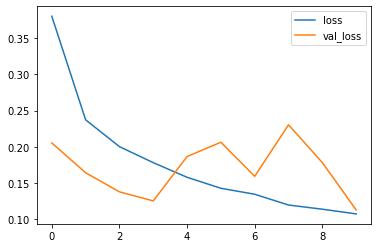

In [37]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()

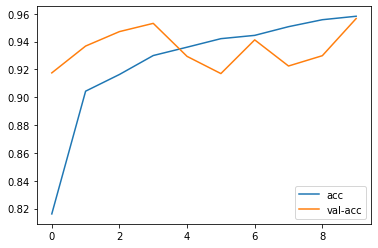

In [38]:
plt.plot(hist.history['acc'],label='acc')
plt.plot(hist.history['val_acc'],label='val-acc')
plt.legend()

In [39]:
def show(layers,images,filter_index=0,size=15):
    """
    layers : conv2d and maxpooling layers
    images : 
    """
    
    fig,ax = plt.subplots(len(images),len(layers)+1)
    fig.set_figheight(size)
    fig.set_figwidth(size)
    for i,img in enumerate(images):
        ax[i][0].imshow(img)
        out = img[np.newaxis,...]
        for l,layer in enumerate(layers):
            out = layer(out)
            ax[i][l+1].imshow(out[0,:,:,filter_index])

In [ ]:
batch = []
for each in train_ds.take(1):
    batch.append(augment(each[0]))

In [40]:
batch = []
for each in next(train_gen):
    batch.append(each)
    break

In [61]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

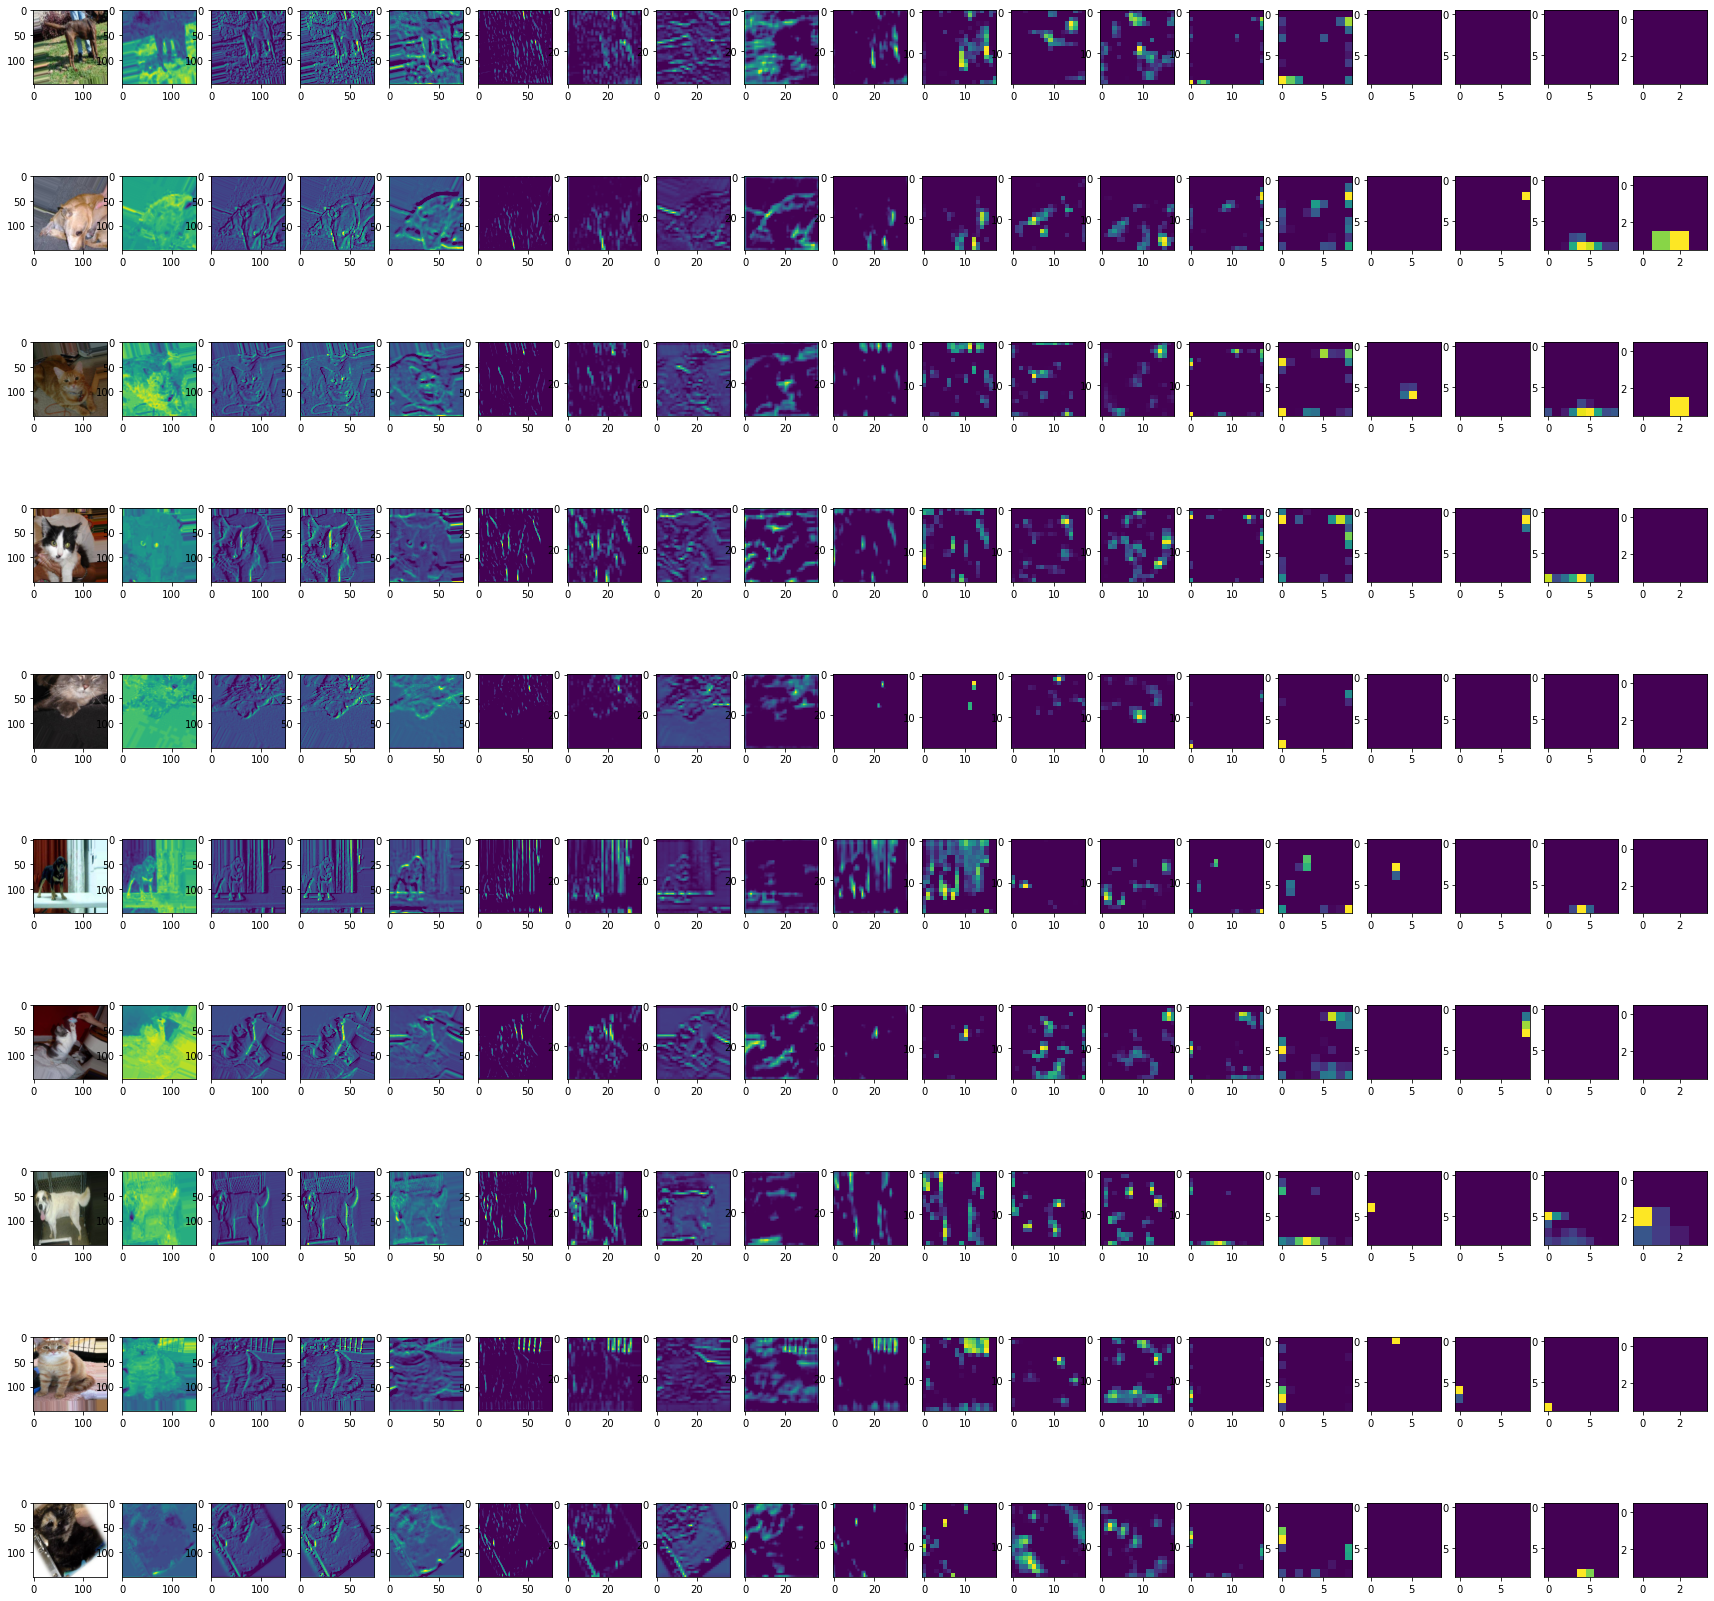

In [63]:
show(conv_base.layers[1:],batch[0][:10],filter_index=12,size=30)

In [ ]:
np.newaxis